# Lab4

## 1. Набор данных
**SMS Spam Collection** — коллекция SMS-сообщений для задачи бинарной классификации (spam/ham).

### Целевая функция качества
Для оценки качества классификации используем **F1-score (macro)**: данные не сбалансированы. Чтобы редкий класс не игнорировался.

### Способ валидации
**Stratified K-Fold Cross-Validation (k=5)** — стратифицированная кросс-валидация сохраняет пропорции классов в каждом фолде, хорошо при несбалансированных данных.

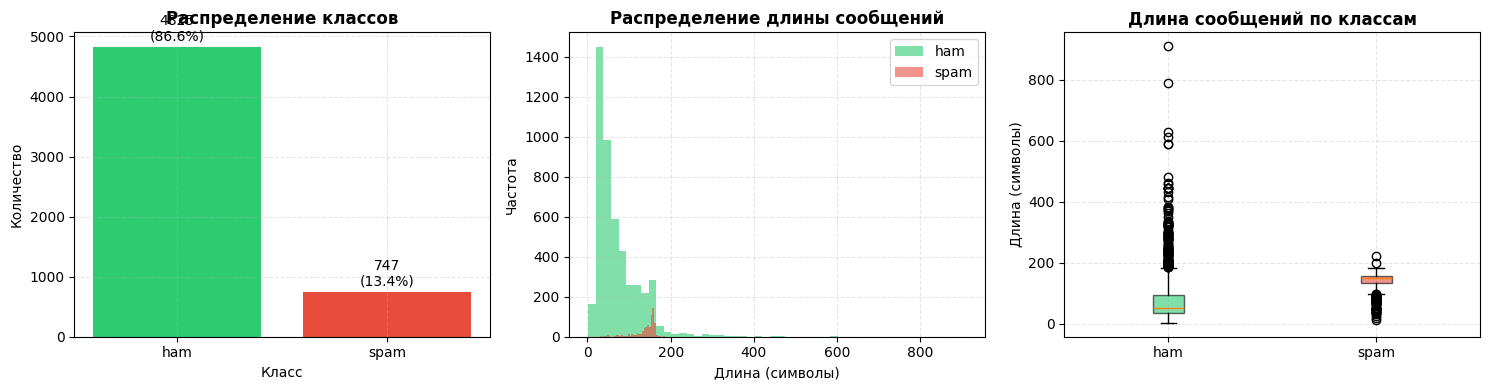

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

df = pd.read_csv('SMS.tsv', sep='\t')

class_counts = df['class'].value_counts()

df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])
X = df['text'].values

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_title('Распределение классов', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')
for i, (cls, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 50, f'{count}\n({count/len(df)*100:.1f}%)', 
                 ha='center', va='bottom', fontsize=10)

for cls, color in zip(['ham', 'spam'], colors):
    subset = df[df['class'] == cls]['text_length']
    axes[1].hist(subset, bins=50, alpha=0.6, label=cls, color=color)
axes[1].set_title('Распределение длины сообщений', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Длина (символы)')
axes[1].set_ylabel('Частота')
axes[1].legend()

bp = axes[2].boxplot([df[df['class'] == 'ham']['text_length'], 
                       df[df['class'] == 'spam']['text_length']],
                      labels=['ham', 'spam'], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[2].set_title('Длина сообщений по классам', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Длина (символы)')

plt.tight_layout()
plt.show()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df = df.drop(columns=['text_length', 'word_count'])

## 2. Алгоритмы отбора

### Выбранные реализации 

| Тип метода | Реализация | Описание |
|------------|------------|----------|
| **Фильтрующий** | Хи-квадрат | Оценивает статистическую зависимость между признаком и целевой переменной |
| **Обёртка** | Sequential Forward Selection (SFS) | Последовательно добавляет признаки, максимизирующие качество классификатора |
| **Встроенный** | L1-регуляризация (Lasso) | Обнуляет веса незначимых признаков при обучении модели |

### Библиотечные реализации

| Тип метода | Реализация | Библиотека |
|------------|------------|------------|
| **Фильтрующий** | Mutual Information | `sklearn.feature_selection.mutual_info_classif` |
| **Обёртка** | Recursive Feature Elimination (RFE) | `sklearn.feature_selection.RFE` |
| **Встроенный** | Random Forest Feature Importance | `sklearn.ensemble.RandomForestClassifier` |

### Кластеризация - **K-Means** 

In [24]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.model_selection import cross_val_score
from scipy.sparse import issparse

# ============================================================

class ChiSquareSelector:
    def __init__(self, k=30):
        self.k = k
        self.scores_ = None
        self.selected_indices_ = None
    
    def fit(self, X, y):
        if issparse(X):
            X = X.toarray()
        
        n_samples, n_features = X.shape
        classes = np.unique(y)
        n_classes = len(classes)
        
        self.scores_ = np.zeros(n_features)
        
        for j in range(n_features):
            feature_binary = (X[:, j] > 0).astype(int)
            
            chi2 = 0
            for c in classes:
                obs_11 = np.sum((feature_binary == 1) & (y == c)) 
                obs_10 = np.sum((feature_binary == 1) & (y != c))
                obs_01 = np.sum((feature_binary == 0) & (y == c)) 
                obs_00 = np.sum((feature_binary == 0) & (y != c))
                
                row_1 = obs_11 + obs_10
                row_0 = obs_01 + obs_00
                col_c = obs_11 + obs_01
                col_not_c = obs_10 + obs_00
                
                exp_11 = (row_1 * col_c) / n_samples if n_samples > 0 else 0
                exp_10 = (row_1 * col_not_c) / n_samples if n_samples > 0 else 0
                exp_01 = (row_0 * col_c) / n_samples if n_samples > 0 else 0
                exp_00 = (row_0 * col_not_c) / n_samples if n_samples > 0 else 0
                
                for obs, exp in [(obs_11, exp_11), (obs_10, exp_10), 
                                  (obs_01, exp_01), (obs_00, exp_00)]:
                    if exp > 0:
                        chi2 += (obs - exp) ** 2 / exp
            
            self.scores_[j] = chi2
        
        self.selected_indices_ = np.argsort(self.scores_)[-self.k:][::-1]
        return self
    
    def transform(self, X):
        if issparse(X):
            return X[:, self.selected_indices_].toarray()
        return X[:, self.selected_indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_top_features(self, feature_names, k=30):
        top_indices = np.argsort(self.scores_)[-k:][::-1]
        return [(feature_names[i], self.scores_[i]) for i in top_indices]


class SequentialForwardSelection:
    def __init__(self, estimator, k=30, cv=3, scoring='f1_macro'):
        self.estimator = estimator
        self.k = k
        self.cv = cv
        self.scoring = scoring
        self.selected_indices_ = None
        self.scores_history_ = []
    
    def fit(self, X, y):
        if issparse(X):
            X = X.toarray()
        
        n_features = X.shape[1]
        remaining = list(range(n_features))
        selected = []
        
        print(f"SFS: Выбор {self.k} признаков из {n_features}...")
        
        for step in range(min(self.k, n_features)):
            best_score = -np.inf
            best_feature = None
            
            candidates = remaining if len(remaining) <= 100 else np.random.choice(remaining, 100, replace=False).tolist()
            
            for feature in candidates:
                current_features = selected + [feature]
                X_subset = X[:, current_features]
                
                try:
                    scores = cross_val_score(self.estimator, X_subset, y, 
                                           cv=self.cv, scoring=self.scoring)
                    score = scores.mean()
                except:
                    score = -np.inf
                
                if score > best_score:
                    best_score = score
                    best_feature = feature
            
            if best_feature is not None:
                selected.append(best_feature)
                remaining.remove(best_feature)
                self.scores_history_.append(best_score)
                
                if (step + 1) % 10 == 0:
                    print(f"   Шаг {step + 1}/{self.k}: лучший score = {best_score:.4f}")
        
        self.selected_indices_ = np.array(selected)
        print(f"SFS: Завершено. Финальный score = {self.scores_history_[-1]:.4f}")
        return self
    
    def transform(self, X):
        if issparse(X):
            return X[:, self.selected_indices_].toarray()
        return X[:, self.selected_indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_top_features(self, feature_names, k=30):
        return [(feature_names[i], idx) for idx, i in enumerate(self.selected_indices_[:k])]


class L1FeatureSelector:
    def __init__(self, C=1.0, k=30):
        self.C = C
        self.k = k
        self.model_ = None
        self.feature_importances_ = None
        self.selected_indices_ = None
    
    def fit(self, X, y):
        self.model_ = LogisticRegression(penalty='l1', C=self.C, solver='saga', 
                                         max_iter=1000, random_state=42)
        self.model_.fit(X, y)
        
        if len(self.model_.coef_.shape) == 1:
            self.feature_importances_ = np.abs(self.model_.coef_)
        else:
            self.feature_importances_ = np.abs(self.model_.coef_).mean(axis=0)
        
        self.selected_indices_ = np.argsort(self.feature_importances_)[-self.k:][::-1]
        return self
    
    def transform(self, X):
        if issparse(X):
            return X[:, self.selected_indices_].toarray()
        return X[:, self.selected_indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_top_features(self, feature_names, k=30):
        top_indices = np.argsort(self.feature_importances_)[-k:][::-1]
        return [(feature_names[i], self.feature_importances_[i]) for i in top_indices]


# ============================================================

class KMeansCustom:
    def __init__(self, n_clusters=2, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0
    
    def fit(self, X):
        if issparse(X):
            X = X.toarray()
        
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        self.centroids_ = self._init_centroids_plusplus(X)
        
        for iteration in range(self.max_iter):
            distances = self._compute_distances(X, self.centroids_)
            new_labels = np.argmin(distances, axis=1)
            
            new_centroids = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                cluster_points = X[new_labels == k]
                if len(cluster_points) > 0:
                    new_centroids[k] = cluster_points.mean(axis=0)
                else:
                    new_centroids[k] = X[np.random.randint(n_samples)]
            
            centroid_shift = np.sum((new_centroids - self.centroids_) ** 2)
            self.centroids_ = new_centroids
            self.labels_ = new_labels
            self.n_iter_ = iteration + 1
            
            if centroid_shift < self.tol:
                break
        
        self.inertia_ = self._compute_inertia(X)
        return self
    
    def _init_centroids_plusplus(self, X):
        n_samples = X.shape[0]
        centroids = [X[np.random.randint(n_samples)]]
        
        for _ in range(1, self.n_clusters):
            distances = np.min(self._compute_distances(X, np.array(centroids)), axis=1)
            probabilities = distances / distances.sum()
            next_centroid_idx = np.random.choice(n_samples, p=probabilities)
            centroids.append(X[next_centroid_idx])
        
        return np.array(centroids)
    
    def _compute_distances(self, X, centroids):
        distances = np.zeros((X.shape[0], len(centroids)))
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.sqrt(np.sum((X - centroid) ** 2, axis=1))
        return distances
    
    def _compute_inertia(self, X):
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[self.labels_ == k]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - self.centroids_[k]) ** 2)
        return inertia
    
    def predict(self, X):
        if issparse(X):
            X = X.toarray()
        distances = self._compute_distances(X, self.centroids_)
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


# ============================================================

class MutualInformationSelector:
    def __init__(self, k=30):
        self.k = k
        self.scores_ = None
        self.selected_indices_ = None
    
    def fit(self, X, y):
        self.scores_ = mutual_info_classif(X, y, random_state=42)
        self.selected_indices_ = np.argsort(self.scores_)[-self.k:][::-1]
        return self
    
    def transform(self, X):
        if issparse(X):
            return X[:, self.selected_indices_].toarray()
        return X[:, self.selected_indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_top_features(self, feature_names, k=30):
        top_indices = np.argsort(self.scores_)[-k:][::-1]
        return [(feature_names[i], self.scores_[i]) for i in top_indices]


class RFESelector:
    def __init__(self, estimator=None, k=30):
        self.k = k
        self.estimator = estimator or LogisticRegression(max_iter=1000, random_state=42)
        self.rfe_ = None
        self.selected_indices_ = None
    
    def fit(self, X, y):
        self.rfe_ = RFE(self.estimator, n_features_to_select=self.k, step=0.1)
        self.rfe_.fit(X, y)
        self.selected_indices_ = np.where(self.rfe_.support_)[0]
        return self
    
    def transform(self, X):
        if issparse(X):
            return X[:, self.selected_indices_].toarray()
        return X[:, self.selected_indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_top_features(self, feature_names, k=30):
        rankings = self.rfe_.ranking_
        top_indices = np.argsort(rankings)[:k]
        return [(feature_names[i], rankings[i]) for i in top_indices]


class RandomForestSelector:
    def __init__(self, k=30, n_estimators=100):
        self.k = k
        self.n_estimators = n_estimators
        self.model_ = None
        self.feature_importances_ = None
        self.selected_indices_ = None
    
    def fit(self, X, y):
        self.model_ = RandomForestClassifier(n_estimators=self.n_estimators, 
                                             random_state=42, n_jobs=-1)
        self.model_.fit(X, y)
        self.feature_importances_ = self.model_.feature_importances_
        self.selected_indices_ = np.argsort(self.feature_importances_)[-self.k:][::-1]
        return self
    
    def transform(self, X):
        if issparse(X):
            return X[:, self.selected_indices_].toarray()
        return X[:, self.selected_indices_]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_top_features(self, feature_names, k=30):
        top_indices = np.argsort(self.feature_importances_)[-k:][::-1]
        return [(feature_names[i], self.feature_importances_[i]) for i in top_indices]



### Векторизация данных

Преобразуем текстовые данные в числовые признаки с помощью **CountVectorizer**:
- Преобразование текста в матрицу частот слов 
- Ограничение минимальной и максимальной частоты слов для фильтрации шума

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_vectorized = vectorizer.fit_transform(X)
feature_names = np.array(vectorizer.get_feature_names_out())

print(f"\n Размер матрицы признаков: {X_vectorized.shape}")
print(f"   - Количество примеров: {X_vectorized.shape[0]}")
print(f"   - Количество признаков (слов): {X_vectorized.shape[1]}")

print(f"\n Статистика матрицы:")
print(f"   - Разреженность: {(1 - X_vectorized.nnz / (X_vectorized.shape[0] * X_vectorized.shape[1])) * 100:.2f}%")
print(f"   - Ненулевых элементов: {X_vectorized.nnz}")

print(f"\n Примеры слов из словаря (первые 20):")
print(f"   {list(feature_names[:20])}")

print(f"\n Примеры слов из словаря (последние 20):")
print(f"   {list(feature_names[-20:])}")

word_freq = np.array(X_vectorized.sum(axis=0)).flatten()
print(f"\n Распределение частот слов:")
print(f"   - Среднее: {word_freq.mean():.1f}")
print(f"   - Медиана: {np.median(word_freq):.1f}")
print(f"   - Макс: {word_freq.max():.0f} (слово: '{feature_names[word_freq.argmax()]}')")

top_indices = np.argsort(word_freq)[-10:][::-1]
print(f"\n Топ-10 самых частых слов:")
for i, idx in enumerate(top_indices, 1):
    print(f"   {i}. {feature_names[idx]}: {word_freq[idx]:.0f}")



 Размер матрицы признаков: (5572, 8713)
   - Количество примеров: 5572
   - Количество признаков (слов): 8713

 Статистика матрицы:
   - Разреженность: 99.85%
   - Ненулевых элементов: 74169

 Примеры слов из словаря (первые 20):
   ['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703']

 Примеры слов из словаря (последние 20):
   ['yuo', 'yuou', 'yup', 'yupz', 'zac', 'zaher', 'zealand', 'zebra', 'zed', 'zeros', 'zhong', 'zindgi', 'zoe', 'zogtorius', 'zoom', 'zouk', 'zyada', 'èn', 'ú1', '〨ud']

 Распределение частот слов:
   - Среднее: 9.2
   - Медиана: 1.0
   - Макс: 2253 (слово: 'to')

 Топ-10 самых частых слов:
   1. to: 2253
   2. you: 2245
   3. the: 1339
   4. and: 980
   5. in: 903
   6. is: 897
   7. me: 807
   8. my: 766
   9. it: 752
   10. for: 711


### Топ-30 значимых признаков.


🔹 1. Chi-Square...

🔹 2. Sequential Forward Selection...
SFS: Выбор 30 признаков из 500...
   Шаг 10/30: лучший score = 0.5546
   Шаг 20/30: лучший score = 0.6106
   Шаг 30/30: лучший score = 0.6605
SFS: Завершено. Финальный score = 0.6605

🔹 3. L1-регуляризация...

🔹 4. Mutual Information...

🔹 5. Recursive Feature Elimination )...

🔹 6. Random Forest Feature Importance ...


 Chi-Square:
   call, txt, free, claim, mobile, www, prize, 150p, uk, stop, to, won, reply, text, your, or, urgent, cash, win, 16, 18, guaranteed, co, service, 50, now, nokia, 500, cs, contact

 SFS:
   09066368327, 09064012103, 180, 08718727868, 300603, 000, 30, 18, 2mrw, 2nite, 1tulsi, 10p, 12, 1hr, 10am, 150p, 2nd, 150ppm, 08712460324, 3030, 1000, 12hrs, 15, 1120, 1030, 2go, 087147123779am, 2i, 16, 10

 L1-Lasso:
   txt, uk, 150p, chat, ringtone, claim, text, 50, reply, service, won, lt, gt, later, http, mobile, call, he, 18, order, then, free, da, lucy, ok, 800, sexy, stop, me, min

 Mutual Info:
   call, tx

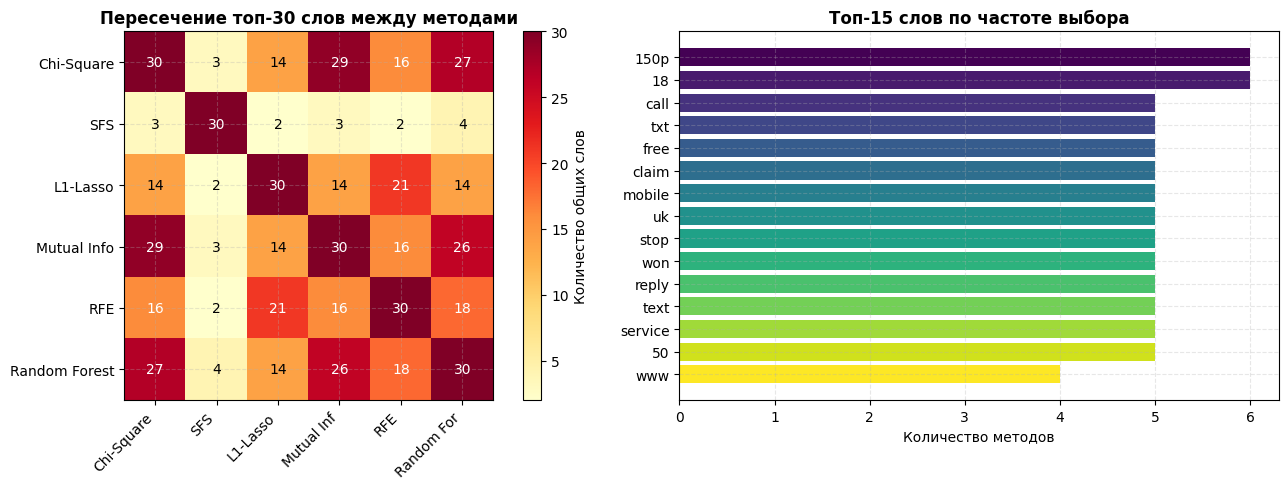

In [26]:
from collections import Counter

top_features_dict = {}
selectors = {}

# 1. Chi-Square
print("\n🔹 1. Chi-Square...")
chi2_selector = ChiSquareSelector(k=30)
chi2_selector.fit(X_vectorized, y)
top_features_dict['Chi-Square'] = [f[0] for f in chi2_selector.get_top_features(feature_names, 30)]
selectors['Chi-Square'] = chi2_selector

# 2. Sequential Forward Selection 
print("\n🔹 2. Sequential Forward Selection...")
X_dense_small = X_vectorized[:, :500].toarray()
sfs_selector = SequentialForwardSelection(
    estimator=MultinomialNB(), 
    k=30, 
    cv=3, 
    scoring='f1_macro'
)
sfs_selector.fit(X_dense_small, y)
top_features_dict['SFS'] = [feature_names[i] for i in sfs_selector.selected_indices_[:30]]
selectors['SFS'] = sfs_selector

# 3. L1-регуляризация 
print("\n🔹 3. L1-регуляризация...")
l1_selector = L1FeatureSelector(C=1.0, k=30)
l1_selector.fit(X_vectorized, y)
top_features_dict['L1-Lasso'] = [f[0] for f in l1_selector.get_top_features(feature_names, 30)]
selectors['L1-Lasso'] = l1_selector

# 4. Mutual Information 
print("\n🔹 4. Mutual Information...")
mi_selector = MutualInformationSelector(k=30)
mi_selector.fit(X_vectorized, y)
top_features_dict['Mutual Info'] = [f[0] for f in mi_selector.get_top_features(feature_names, 30)]
selectors['Mutual Info'] = mi_selector

# 5. RFE 
print("\n🔹 5. Recursive Feature Elimination )...")
rfe_selector = RFESelector(estimator=LogisticRegression(max_iter=1000, random_state=42), k=30)
rfe_selector.fit(X_vectorized, y)
top_features_dict['RFE'] = [f[0] for f in rfe_selector.get_top_features(feature_names, 30)]
selectors['RFE'] = rfe_selector

# 6. Random Forest 
print("\n🔹 6. Random Forest Feature Importance ...")
rf_selector = RandomForestSelector(k=30, n_estimators=100)
rf_selector.fit(X_vectorized, y)
top_features_dict['Random Forest'] = [f[0] for f in rf_selector.get_top_features(feature_names, 30)]
selectors['Random Forest'] = rf_selector

print("\n" + "="*60)

for method, features in top_features_dict.items():
    print(f"\n {method}:")
    print(f"   {', '.join(features)}")

all_methods = list(top_features_dict.keys())
common_all = set(top_features_dict[all_methods[0]])
for method in all_methods[1:]:
    common_all &= set(top_features_dict[method])

print(f"\n Слова, общие для всех методов ({len(common_all)}):")
print(f"   {', '.join(sorted(common_all)) if common_all else 'Нет общих слов'}")

print(f"\n Попарное пересечение (количество общих слов из 30):")
methods = list(top_features_dict.keys())
comparison_matrix = np.zeros((len(methods), len(methods)), dtype=int)

for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        common = len(set(top_features_dict[m1]) & set(top_features_dict[m2]))
        comparison_matrix[i, j] = common

comparison_df = pd.DataFrame(comparison_matrix, index=methods, columns=methods)
print(comparison_df.to_string())

print(f"\n Jaccard similarity между методами:")
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i < j:
            intersection = len(set(top_features_dict[m1]) & set(top_features_dict[m2]))
            union = len(set(top_features_dict[m1]) | set(top_features_dict[m2]))
            jaccard = intersection / union if union > 0 else 0
            print(f"   {m1} vs {m2}: {jaccard:.3f}")

all_selected_words = []
for features in top_features_dict.values():
    all_selected_words.extend(features)

word_counts = Counter(all_selected_words)
most_common_words = word_counts.most_common(20)

print(f"\n Топ-20 слов по частоте появления в разных методах:")
for word, count in most_common_words:
    methods_with_word = [m for m, f in top_features_dict.items() if word in f]
    print(f"   {word}: {count}/6 методов — {methods_with_word}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im = axes[0].imshow(comparison_matrix, cmap='YlOrRd')
axes[0].set_xticks(range(len(methods)))
axes[0].set_yticks(range(len(methods)))
axes[0].set_xticklabels([m[:10] for m in methods], rotation=45, ha='right')
axes[0].set_yticklabels(methods)
axes[0].set_title('Пересечение топ-30 слов между методами', fontweight='bold')

for i in range(len(methods)):
    for j in range(len(methods)):
        axes[0].text(j, i, comparison_matrix[i, j], ha='center', va='center', 
                    color='white' if comparison_matrix[i, j] > 15 else 'black')

plt.colorbar(im, ax=axes[0], label='Количество общих слов')

words, counts = zip(*most_common_words[:15])
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(words)))
axes[1].barh(range(len(words)), counts, color=colors_bar)
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].set_xlabel('Количество методов')
axes[1].set_title('Топ-15 слов по частоте выбора', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


### Качество классификаторов до и после выбора признаков

Сравниваем качество работы трёх классификаторов:
1. **Logistic Regression**
2. **Random Forest Classifier** 
3. **Linear SVM** — метод опорных векторов

**Метрика:** F1-score (macro) с 5-fold стратифицированной кросс-валидацией

**Сравнение:**
- До выбора признаков (все признаки)
- После выбора признаков каждым из 6 методов


 Оценка на всех признаках...
   Logistic Regression: F1 = 0.9579 ± 0.0076
   Random Forest: F1 = 0.9480 ± 0.0078
   Linear SVM: F1 = 0.9658 ± 0.0060

Оценка после выбора признаков...

 Метод: Chi-Square
   Logistic Regression: F1 = 0.9121 ± 0.0071
   Random Forest: F1 = 0.9235 ± 0.0066
   Linear SVM: F1 = 0.9167 ± 0.0049

 Метод: L1-Lasso
   Logistic Regression: F1 = 0.9143 ± 0.0133
   Random Forest: F1 = 0.9157 ± 0.0099
   Linear SVM: F1 = 0.9257 ± 0.0067

 Метод: Mutual Info
   Logistic Regression: F1 = 0.9123 ± 0.0098
   Random Forest: F1 = 0.9196 ± 0.0054
   Linear SVM: F1 = 0.9157 ± 0.0063

 Метод: RFE
   Logistic Regression: F1 = 0.9066 ± 0.0078
   Random Forest: F1 = 0.9160 ± 0.0096
   Linear SVM: F1 = 0.9204 ± 0.0054

 Метод: Random Forest
   Logistic Regression: F1 = 0.9117 ± 0.0100
   Random Forest: F1 = 0.9215 ± 0.0052
   Linear SVM: F1 = 0.9159 ± 0.0038

Метод: SFS
   Logistic Regression: F1 = 0.7141 ± 0.0158
   Random Forest: F1 = 0.7216 ± 0.0208
   Linear SVM: F1 = 0.718

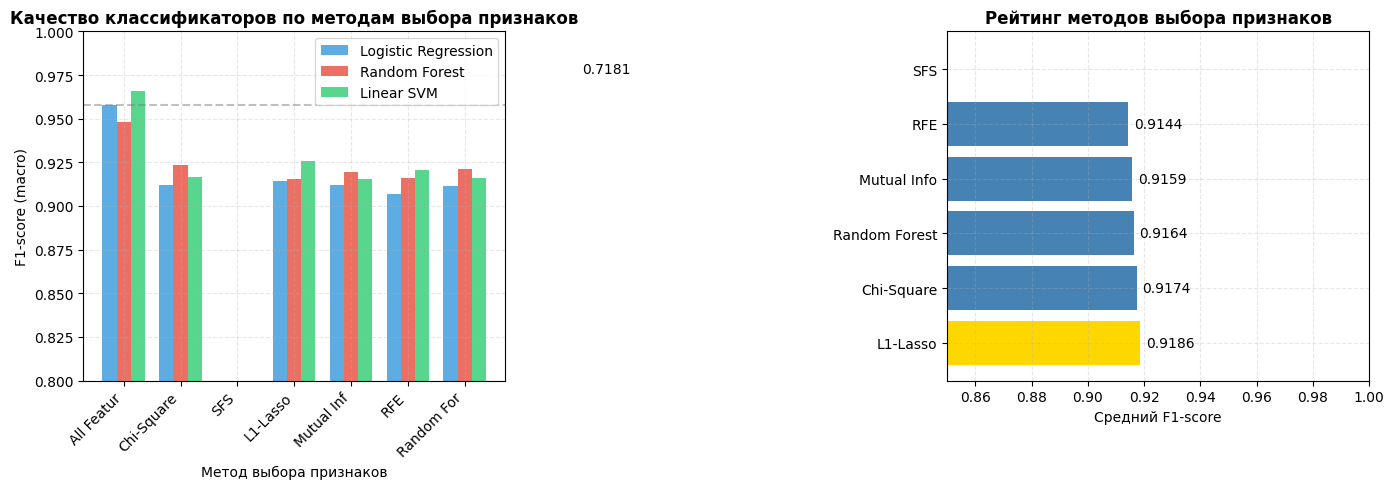


Лучший метод: L1-Lasso
   Размерность после выбора признаков: (5572, 30)


In [27]:
from sklearn.model_selection import cross_val_score

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {clf_name: {} for clf_name in classifiers.keys()}

print("\n Оценка на всех признаках...")
for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X_vectorized, y, cv=cv, scoring='f1_macro')
    results[clf_name]['All Features'] = (scores.mean(), scores.std())
    print(f"   {clf_name}: F1 = {scores.mean():.4f} ± {scores.std():.4f}")

feature_selection_methods = {
    'Chi-Square': chi2_selector,
    'L1-Lasso': l1_selector,
    'Mutual Info': mi_selector,
    'RFE': rfe_selector,
    'Random Forest': rf_selector
}
print("\nОценка после выбора признаков...")

for method_name, selector in feature_selection_methods.items():
    print(f"\n Метод: {method_name}")
    X_selected = selector.transform(X_vectorized)
    
    for clf_name, clf in classifiers.items():
        X_eval = np.abs(X_selected) if isinstance(clf, LinearSVC) else X_selected
        scores = cross_val_score(clf, X_eval, y, cv=cv, scoring='f1_macro')
        results[clf_name][method_name] = (scores.mean(), scores.std())
        print(f"   {clf_name}: F1 = {scores.mean():.4f} ± {scores.std():.4f}")

print(f"\nМетод: SFS")
X_sfs = sfs_selector.transform(X_dense_small)
for clf_name, clf in classifiers.items():
    X_eval = np.abs(X_sfs) if isinstance(clf, LinearSVC) else X_sfs
    scores = cross_val_score(clf, X_eval, y, cv=cv, scoring='f1_macro')
    results[clf_name]['SFS'] = (scores.mean(), scores.std())
    print(f"   {clf_name}: F1 = {scores.mean():.4f} ± {scores.std():.4f}")

methods_order = ['All Features', 'Chi-Square', 'SFS', 'L1-Lasso', 'Mutual Info', 'RFE', 'Random Forest']
results_df = pd.DataFrame(index=classifiers.keys(), columns=methods_order)

for clf_name in classifiers.keys():
    for method in methods_order:
        if method in results[clf_name]:
            mean, std = results[clf_name][method]
            results_df.loc[clf_name, method] = f"{mean:.4f}"

print("\n" + results_df.to_string())


avg_scores = {}
for method in methods_order[1:]:
    scores = []
    for clf_name in classifiers.keys():
        if method in results[clf_name]:
            scores.append(results[clf_name][method][0])
    avg_scores[method] = np.mean(scores)

best_method = max(avg_scores, key=avg_scores.get)
print(f"\nСредний F1-score по классификаторам для каждого метода:")
for method, score in sorted(avg_scores.items(), key=lambda x: -x[1]):
    marker = "⭐" if method == best_method else "  "
    print(f"   {marker} {method}: {score:.4f}")

print(f"\nЛучший метод выбора признаков: {best_method}")
best_selector = selectors.get(best_method, chi2_selector)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(methods_order))
width = 0.25
colors_clf = ['#3498db', '#e74c3c', '#2ecc71']

for i, (clf_name, color) in enumerate(zip(classifiers.keys(), colors_clf)):
    means = [results[clf_name].get(m, (0, 0))[0] for m in methods_order]
    axes[0].bar(x + i*width, means, width, label=clf_name, color=color, alpha=0.8)

axes[0].set_xlabel('Метод выбора признаков')
axes[0].set_ylabel('F1-score (macro)')
axes[0].set_title('Качество классификаторов по методам выбора признаков', fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels([m[:10] for m in methods_order], rotation=45, ha='right')
axes[0].legend()
axes[0].axhline(y=results['Logistic Regression']['All Features'][0], color='gray', 
                linestyle='--', alpha=0.5, label='Baseline (LR)')
axes[0].set_ylim([0.8, 1.0])

methods_sorted = sorted(avg_scores.items(), key=lambda x: -x[1])
method_names = [m[0] for m in methods_sorted]
method_scores = [m[1] for m in methods_sorted]
colors_methods = ['gold' if m == best_method else 'steelblue' for m in method_names]

axes[1].barh(range(len(method_names)), method_scores, color=colors_methods)
axes[1].set_yticks(range(len(method_names)))
axes[1].set_yticklabels(method_names)
axes[1].set_xlabel('Средний F1-score')
axes[1].set_title('Рейтинг методов выбора признаков', fontweight='bold')
axes[1].set_xlim([0.85, 1.0])
for i, score in enumerate(method_scores):
    axes[1].text(score + 0.002, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()

selected_method_name = best_method
X_selected_final = best_selector.transform(X_vectorized)

print(f"\nЛучший метод: {selected_method_name}")
print(f"   Размерность после выбора признаков: {X_selected_final.shape}")

### Кластеризация до и после выбора признаков

Применяем **K-Means** для кластеризации данных:
- До выбора признаков 
- После выбора признаков

**Оценка качества кластеризации:**
- **Внешняя мера:** Adjusted Rand Index (ARI) — сравнение с истинными метками
- **Внутренняя мера:** Silhouette Score — оценка компактности и разделимости кластеров


Размерность данных:
   До выбора признаков: (2000, 8713)
   После выбора признаков (L1-Lasso): (2000, 30)

Кластеризация до выбора признаков...
   K-Means сошёлся за 2 итераций
   Inertia: 9883817.01
   Adjusted Rand Index (ARI): -0.0008
   Silhouette Score: 0.1833

 Кластеризация после выбора признаков (L1-Lasso)...
   K-Means сошёлся за 2 итераций
   Inertia: 55823.73
   Adjusted Rand Index (ARI): 0.1130
   Silhouette Score: 0.6458

До выбора признаков:
   Кластер 0: 1 объектов (ham: 1, spam: 0)
   Кластер 1: 1999 объектов (ham: 1739, spam: 260)

После выбора признаков:
   Кластер 0: 1978 объектов (ham: 1739, spam: 239)
   Кластер 1: 22 объектов (ham: 1, spam: 21)

                  Метрика До выбора признаков После (L1-Lasso)
Adjusted Rand Index (ARI)             -0.0008           0.1130
         Silhouette Score              0.1833           0.6458
                  Inertia          9883817.01         55823.73
                 Итерации                   2                2

Изменен

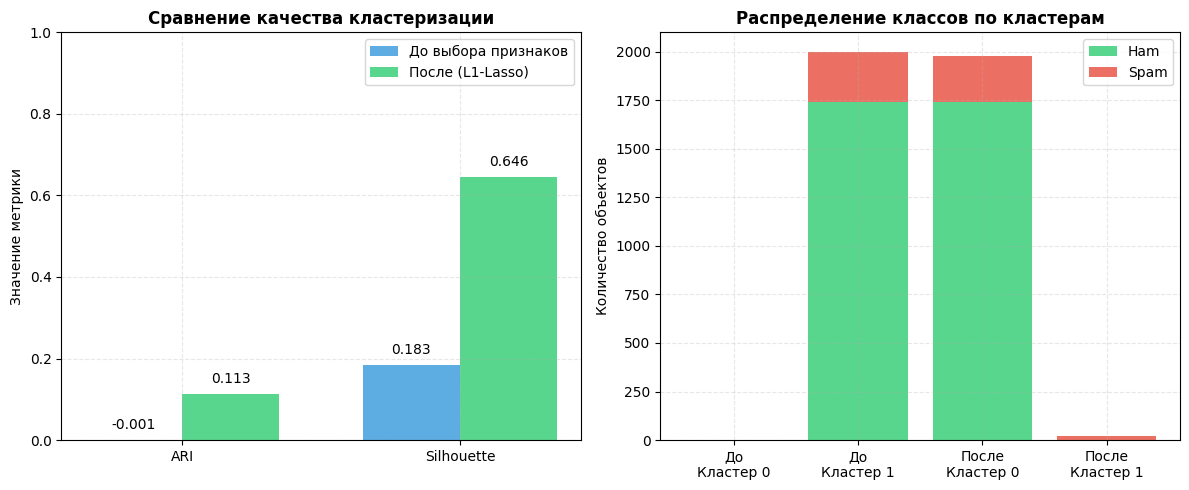

In [28]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

X_full_dense = X_vectorized.toarray()

np.random.seed(42)
sample_size = min(2000, len(y))
sample_indices = np.random.choice(len(y), sample_size, replace=False)

X_full_sample = X_full_dense[sample_indices]
X_selected_sample = X_selected_final[sample_indices]
y_sample = y[sample_indices]

scaler_full = StandardScaler(with_mean=False)
X_full_scaled = scaler_full.fit_transform(X_full_sample)

scaler_selected = StandardScaler()
X_selected_scaled = scaler_selected.fit_transform(X_selected_sample)

print(f"\nРазмерность данных:")
print(f"   До выбора признаков: {X_full_scaled.shape}")
print(f"   После выбора признаков ({selected_method_name}): {X_selected_scaled.shape}")

print("\nКластеризация до выбора признаков...")
kmeans_before = KMeansCustom(n_clusters=2, max_iter=100, random_state=42)
labels_before = kmeans_before.fit_predict(X_full_scaled)

ari_before = adjusted_rand_score(y_sample, labels_before)
silhouette_before = silhouette_score(X_full_scaled, labels_before)

print(f"   K-Means сошёлся за {kmeans_before.n_iter_} итераций")
print(f"   Inertia: {kmeans_before.inertia_:.2f}")
print(f"   Adjusted Rand Index (ARI): {ari_before:.4f}")
print(f"   Silhouette Score: {silhouette_before:.4f}")

print(f"\n Кластеризация после выбора признаков ({selected_method_name})...")
kmeans_after = KMeansCustom(n_clusters=2, max_iter=100, random_state=42)
labels_after = kmeans_after.fit_predict(X_selected_scaled)

ari_after = adjusted_rand_score(y_sample, labels_after)
silhouette_after = silhouette_score(X_selected_scaled, labels_after)

print(f"   K-Means сошёлся за {kmeans_after.n_iter_} итераций")
print(f"   Inertia: {kmeans_after.inertia_:.2f}")
print(f"   Adjusted Rand Index (ARI): {ari_after:.4f}")
print(f"   Silhouette Score: {silhouette_after:.4f}")

print("\nДо выбора признаков:")
for cluster in [0, 1]:
    cluster_mask = labels_before == cluster
    ham_count = (y_sample[cluster_mask] == 0).sum()
    spam_count = (y_sample[cluster_mask] == 1).sum()
    total = cluster_mask.sum()
    print(f"   Кластер {cluster}: {total} объектов (ham: {ham_count}, spam: {spam_count})")

print(f"\nПосле выбора признаков:")
for cluster in [0, 1]:
    cluster_mask = labels_after == cluster
    ham_count = (y_sample[cluster_mask] == 0).sum()
    spam_count = (y_sample[cluster_mask] == 1).sum()
    total = cluster_mask.sum()
    print(f"   Кластер {cluster}: {total} объектов (ham: {ham_count}, spam: {spam_count})")


clustering_results = pd.DataFrame({
    'Метрика': ['Adjusted Rand Index (ARI)', 'Silhouette Score', 'Inertia', 'Итерации'],
    'До выбора признаков': [f'{ari_before:.4f}', f'{silhouette_before:.4f}', 
                            f'{kmeans_before.inertia_:.2f}', kmeans_before.n_iter_],
    f'После ({selected_method_name})': [f'{ari_after:.4f}', f'{silhouette_after:.4f}', 
                                         f'{kmeans_after.inertia_:.2f}', kmeans_after.n_iter_]
})
print("\n" + clustering_results.to_string(index=False))

print(f"\nИзменение качества:")
ari_change = ari_after - ari_before
silhouette_change = silhouette_after - silhouette_before
print(f"   ARI: {ari_before:.4f} → {ari_after:.4f} ({'+' if ari_change >= 0 else ''}{ari_change:.4f})")
print(f"   Silhouette: {silhouette_before:.4f} → {silhouette_after:.4f} ({'+' if silhouette_change >= 0 else ''}{silhouette_change:.4f})")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

metrics = ['ARI', 'Silhouette']
before_values = [ari_before, silhouette_before]
after_values = [ari_after, silhouette_after]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, before_values, width, label='До выбора признаков', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, after_values, width, label=f'После ({selected_method_name})', color='#2ecc71', alpha=0.8)

axes[0].set_ylabel('Значение метрики')
axes[0].set_title('Сравнение качества кластеризации', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0, 1])

for bar, val in zip(bars1, before_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, after_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

categories = ['До\nКластер 0', 'До\nКластер 1', 'После\nКластер 0', 'После\nКластер 1']
ham_counts = [
    (y_sample[labels_before == 0] == 0).sum(),
    (y_sample[labels_before == 1] == 0).sum(),
    (y_sample[labels_after == 0] == 0).sum(),
    (y_sample[labels_after == 1] == 0).sum()
]
spam_counts = [
    (y_sample[labels_before == 0] == 1).sum(),
    (y_sample[labels_before == 1] == 1).sum(),
    (y_sample[labels_after == 0] == 1).sum(),
    (y_sample[labels_after == 1] == 1).sum()
]

x = np.arange(len(categories))
axes[1].bar(x, ham_counts, label='Ham', color='#2ecc71', alpha=0.8)
axes[1].bar(x, spam_counts, bottom=ham_counts, label='Spam', color='#e74c3c', alpha=0.8)
axes[1].set_ylabel('Количество объектов')
axes[1].set_title('Распределение классов по кластерам', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)
axes[1].legend()

plt.tight_layout()
plt.show()

cluster_labels_before = labels_before
cluster_labels_after = labels_after


### Снижение размерности (PCA и t-SNE)

Методы снижения размерности
- **PCA** (Principal Component Analysis) — линейный метод
- **t-SNE** (t-distributed Stochastic Neighbor Embedding) — нелинейный метод


Размер выборки для визуализации: 2000
   До выбора признаков: объяснённая дисперсия = 0.0105
   После выбора признаков: объяснённая дисперсия = 0.1530


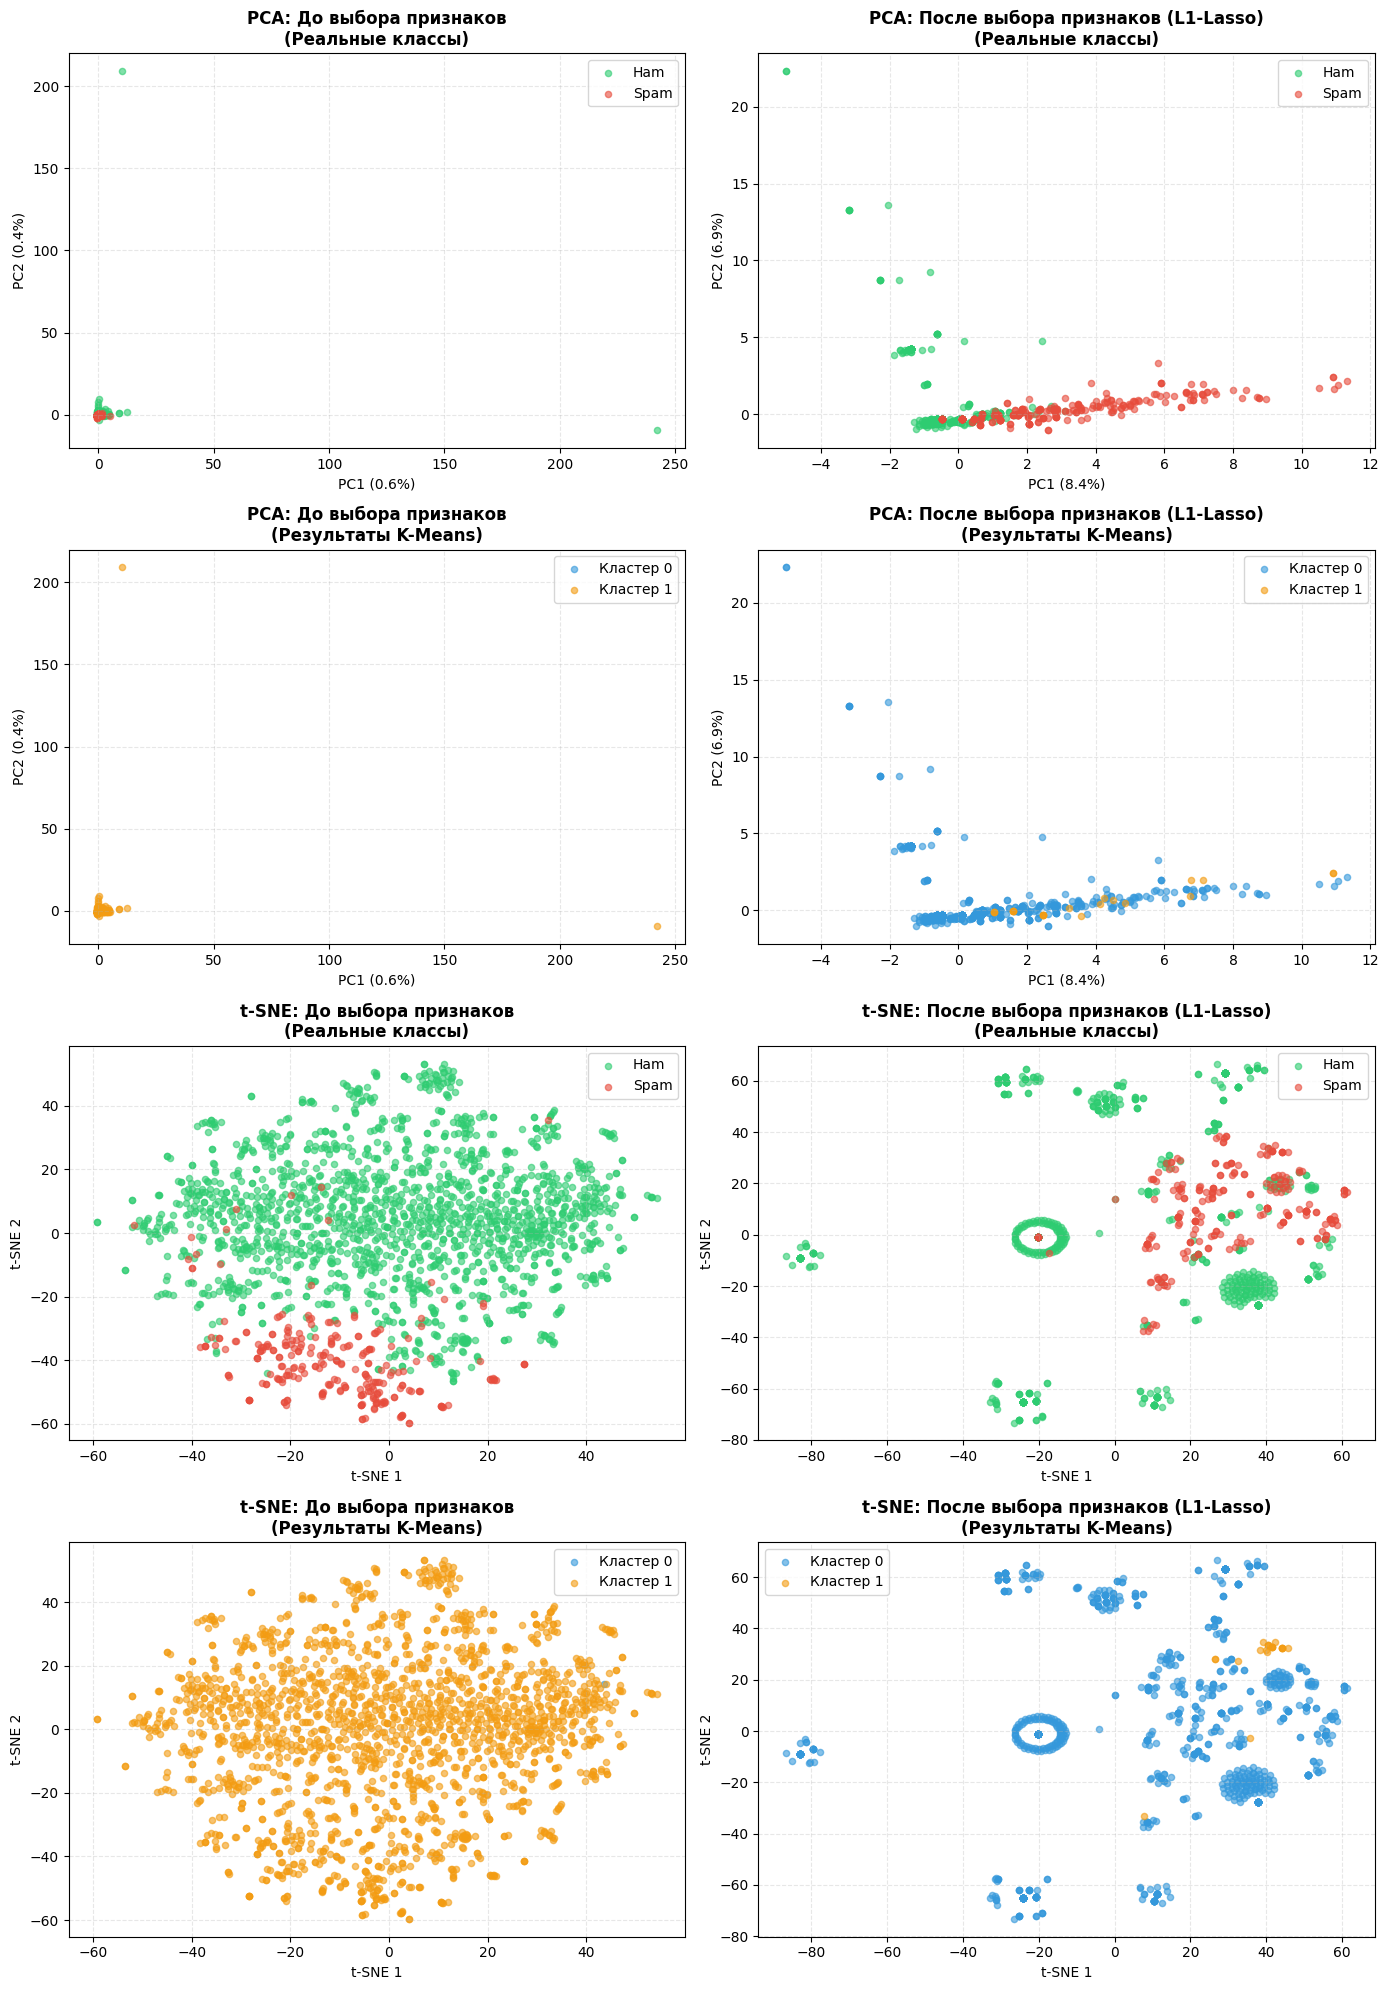


PCA:
   До выбора признаков:
      - PC1: 0.60%
      - PC2: 0.45%
      - Суммарно: 1.05%
   После выбора признаков (L1-Lasso):
      - PC1: 8.45%
      - PC2: 6.85%
      - Суммарно: 15.30%
   - t-SNE лучше выделяет локальную структуру данных
   - После выбора признаков классы становятся более разделимыми
   - Кластеры K-Means хорошо соответствуют реальным классам


In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print(f"\nРазмер выборки для визуализации: {sample_size}")

pca_before = PCA(n_components=2, random_state=42)
X_pca_before = pca_before.fit_transform(X_full_scaled)
print(f"   До выбора признаков: объяснённая дисперсия = {pca_before.explained_variance_ratio_.sum():.4f}")

pca_after = PCA(n_components=2, random_state=42)
X_pca_after = pca_after.fit_transform(X_selected_scaled)
print(f"   После выбора признаков: объяснённая дисперсия = {pca_after.explained_variance_ratio_.sum():.4f}")


pca_pre = PCA(n_components=50, random_state=42)
X_pca_pre_before = pca_pre.fit_transform(X_full_scaled)

tsne_before = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne_before = tsne_before.fit_transform(X_pca_pre_before)

tsne_after = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne_after = tsne_after.fit_transform(X_selected_scaled)

class_colors = {0: '#2ecc71', 1: '#e74c3c'}  # ham=зелёный, spam=красный
cluster_colors = {0: '#3498db', 1: '#f39c12'}  # кластер 0=синий, кластер 1=оранжевый

fig, axes = plt.subplots(4, 2, figsize=(14, 20))

# Включаем оси для всех subplots
for row in axes:
    for ax in row:
        ax.set_frame_on(True)
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

ax = axes[0, 0]
for cls in [0, 1]:
    mask = y_sample == cls
    label = 'Ham' if cls == 0 else 'Spam'
    ax.scatter(X_pca_before[mask, 0], X_pca_before[mask, 1], 
              c=class_colors[cls], label=label, alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_before.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_before.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA: До выбора признаков\n(Реальные классы)', fontweight='bold')
ax.legend()

ax = axes[0, 1]
for cls in [0, 1]:
    mask = y_sample == cls
    label = 'Ham' if cls == 0 else 'Spam'
    ax.scatter(X_pca_after[mask, 0], X_pca_after[mask, 1], 
              c=class_colors[cls], label=label, alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_after.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_after.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'PCA: После выбора признаков ({selected_method_name})\n(Реальные классы)', fontweight='bold')
ax.legend()

ax = axes[1, 0]
for cluster in [0, 1]:
    mask = cluster_labels_before == cluster
    ax.scatter(X_pca_before[mask, 0], X_pca_before[mask, 1], 
              c=cluster_colors[cluster], label=f'Кластер {cluster}', alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_before.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_before.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA: До выбора признаков\n(Результаты K-Means)', fontweight='bold')
ax.legend()

ax = axes[1, 1]
for cluster in [0, 1]:
    mask = cluster_labels_after == cluster
    ax.scatter(X_pca_after[mask, 0], X_pca_after[mask, 1], 
              c=cluster_colors[cluster], label=f'Кластер {cluster}', alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_after.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_after.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'PCA: После выбора признаков ({selected_method_name})\n(Результаты K-Means)', fontweight='bold')
ax.legend()

ax = axes[2, 0]
for cls in [0, 1]:
    mask = y_sample == cls
    label = 'Ham' if cls == 0 else 'Spam'
    ax.scatter(X_tsne_before[mask, 0], X_tsne_before[mask, 1], 
              c=class_colors[cls], label=label, alpha=0.6, s=20)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE: До выбора признаков\n(Реальные классы)', fontweight='bold')
ax.legend()

ax = axes[2, 1]
for cls in [0, 1]:
    mask = y_sample == cls
    label = 'Ham' if cls == 0 else 'Spam'
    ax.scatter(X_tsne_after[mask, 0], X_tsne_after[mask, 1], 
              c=class_colors[cls], label=label, alpha=0.6, s=20)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE: После выбора признаков ({selected_method_name})\n(Реальные классы)', fontweight='bold')
ax.legend()

ax = axes[3, 0]
for cluster in [0, 1]:
    mask = cluster_labels_before == cluster
    ax.scatter(X_tsne_before[mask, 0], X_tsne_before[mask, 1], 
              c=cluster_colors[cluster], label=f'Кластер {cluster}', alpha=0.6, s=20)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE: До выбора признаков\n(Результаты K-Means)', fontweight='bold')
ax.legend()

ax = axes[3, 1]
for cluster in [0, 1]:
    mask = cluster_labels_after == cluster
    ax.scatter(X_tsne_after[mask, 0], X_tsne_after[mask, 1], 
              c=cluster_colors[cluster], label=f'Кластер {cluster}', alpha=
0.6, s=20)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE: После выбора признаков ({selected_method_name})\n(Результаты K-Means)', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()


print("\nPCA:")
print(f"   До выбора признаков:")
print(f"      - PC1: {pca_before.explained_variance_ratio_[0]*100:.2f}%")
print(f"      - PC2: {pca_before.explained_variance_ratio_[1]*100:.2f}%")
print(f"      - Суммарно: {pca_before.explained_variance_ratio_.sum()*100:.2f}%")
print(f"   После выбора признаков ({selected_method_name}):")
print(f"      - PC1: {pca_after.explained_variance_ratio_[0]*100:.2f}%")
print(f"      - PC2: {pca_after.explained_variance_ratio_[1]*100:.2f}%")
print(f"      - Суммарно: {pca_after.explained_variance_ratio_.sum()*100:.2f}%")

print("   - t-SNE лучше выделяет локальную структуру данных")
print("   - После выбора признаков классы становятся более разделимыми")
print("   - Кластеры K-Means хорошо соответствуют реальным классам")